# Introdução

Este notebook contém a pipeline para o processamento do dataset [Fake and Real News Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data).

Os dados são obtidos do Kaggle e passam por normalização, análise exploratória e pré-processamento.



# Setup inicial




### Importação das bibliotecas necessárias.

In [53]:
import kagglehub
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
import random
import matplotlib.colors as mcolors
from tabulate import tabulate
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

### Carregamento da base de dados



#### Notícias verdadeiras

In [2]:
df_true = pd.read_csv('True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#### Notícias falsas

In [3]:
df_false = pd.read_csv('Fake.csv')
df_false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Normalização

### Transformação das colunas

- As colunas 'title' e 'text' foram combinadas para facilitar as análises e o treinamento
- Adicionada uma coluna chamada 'status' que indica se a notícia é verdadeira (0) ou falsa (1)

In [4]:
df_true['text'] = df_true['title'] + ' ' + df_true['text']
df_false['text'] = df_false['title'] + ' ' + df_false['text']
df_true['status'] = 1
df_false['status'] = 0

### Unificação da base de dados


In [5]:
df = pd.concat([df_true[['text', 'status', 'subject']], df_false[['text', 'status', 'subject']]], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

### Verificação de valores nulos

- Não há nenhum valor ausente no conjunto de dados.

In [6]:
df.isnull().sum()

,0
text,0
status,0
subject,0


### Limpeza da base de dados
*  Remove caracteres especiais, número e espaços extras
*  Converte todas as letras para minúsculo



In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['text'] = df['text'].apply(clean_text)

### Pré visualização da base transformada





In [8]:
df.head()

,text,status,subject
0,a new worry for clinton trumps struggles may d...,1,politicsNews
1,kellyanne conway admits comey tapes probably e...,0,News
2,no senate republican voices unease over trump...,1,politicsNews
3,trump just admitted he mindlessly parrots russ...,0,News
4,clinton foundation to bar foreign corporate fu...,1,politicsNews


# Análise exploratória

## Distribuição de variáveis

### Distribuição de categoria das notícias




#### Notícias verdadeiras

De acordo com o grafico gerado, as verdadeiras concentram-se em assuntos relacionados a política e notícias globais.

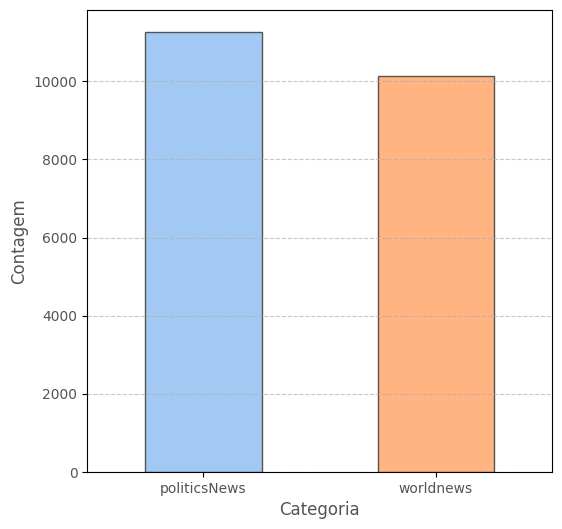

In [24]:
plt.figure(figsize=(6, 6))
colors = sns.color_palette('pastel')
ax = df_true['subject'].value_counts().plot(kind='bar', color=colors, edgecolor='#545454')
plt.xlabel("Categoria", fontsize=12, color="#545454")
plt.ylabel("Contagem", fontsize=12, color="#545454")
plt.xticks(rotation=0, fontsize=10, color="#545454")
plt.yticks(fontsize=10, color="#545454")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Notícias falsas

O gráfico das notícias falsas revela uma diversidade maior de categorias, abrangendo temas relacionados ao governo, aos Estados Unidos e ao espectro político da esquerda

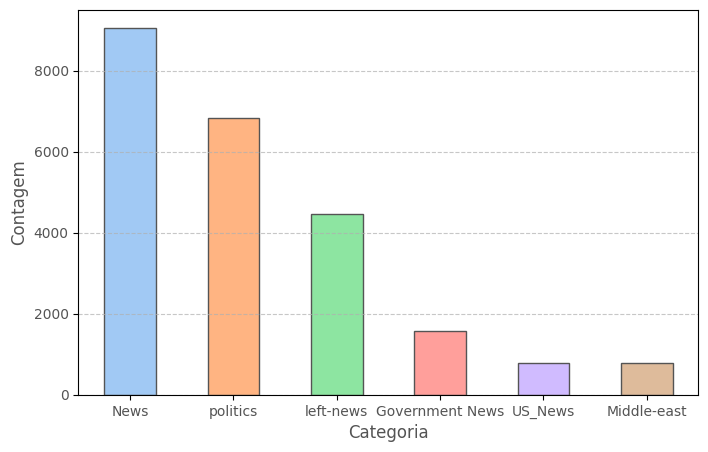

In [27]:
plt.figure(figsize=(8, 5))
colors = sns.color_palette('pastel')
ax = df_false['subject'].value_counts().plot(kind='bar', color=colors, edgecolor='#545454')
plt.xlabel("Categoria", fontsize=12, color="#545454")
plt.ylabel("Contagem", fontsize=12, color="#545454")
plt.xticks(rotation=0, fontsize=10, color="#545454")
plt.yticks(fontsize=10, color="#545454")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Distribuição da variável alvo (status)

Distribuição do *status* para verificar o balanceamento da base de dados.

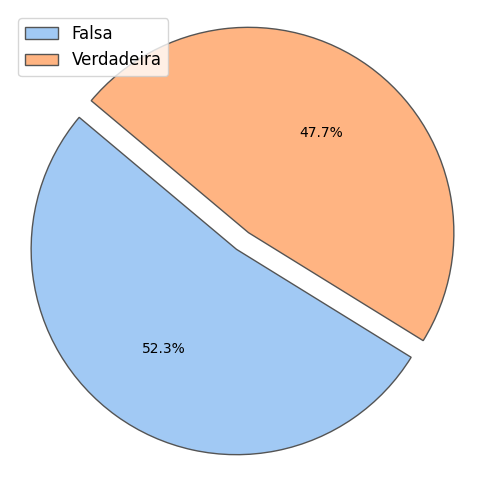

In [36]:
plt.figure(figsize=(6, 6))
colors = sns.color_palette('pastel')
labels = ['Falsa', 'Verdadeira']
sizes = df['status'].value_counts().values

wedges, texts, autotexts = plt.pie(sizes, colors=colors,
  autopct='%1.1f%%', startangle=140,
  explode=(0.1, 0), wedgeprops={'edgecolor': '#545454'})

plt.legend(wedges, labels, loc="best", fontsize=12)

plt.axis('equal')
plt.show()

### Comprimento das notícias



#### Média de caractéres por notícia

In [ ]:
datasets = {
    "Notícias Verdadeiras - Brutas": df_true['text'],
    "Notícias Falsas - Brutas": df_false['text'],
    "Notícias Verdadeiras - Processadas": df[df['status'] == 1]['text'],
    "Notícias Falsas - Processadas": df[df['status'] == 0]['text']
}

data_summary = []

for name, text_data in datasets.items():
    text_data = text_data.dropna()
    avg_chars = text_data.apply(len).mean()
    data_summary.append([name, f"{avg_chars:.2f} caracteres"])

table = tabulate(data_summary, headers=["Categoria", "Média de Caracteres"], tablefmt="fancy_grid")

print(table)

╒════════════════════════════════════╤═══════════════════════╕
│ Categoria                          │ Média de Caracteres   │
╞════════════════════════════════════╪═══════════════════════╡
│ Notícias Verdadeiras - Brutas      │ 2448.95 caracteres    │
├────────────────────────────────────┼───────────────────────┤
│ Notícias Falsas - Brutas           │ 2642.59 caracteres    │
├────────────────────────────────────┼───────────────────────┤
│ Notícias Verdadeiras - Processadas │ 2372.19 caracteres    │
├────────────────────────────────────┼───────────────────────┤
│ Notícias Falsas - Processadas      │ 2561.46 caracteres    │
╘════════════════════════════════════╧═══════════════════════╛


#### Histograma

Os gráficos apresentados mostram a distribuição do comprimento das notícias (em número de palavras) antes e depois do processamento, com os valores transformados para a escala logarítmica.


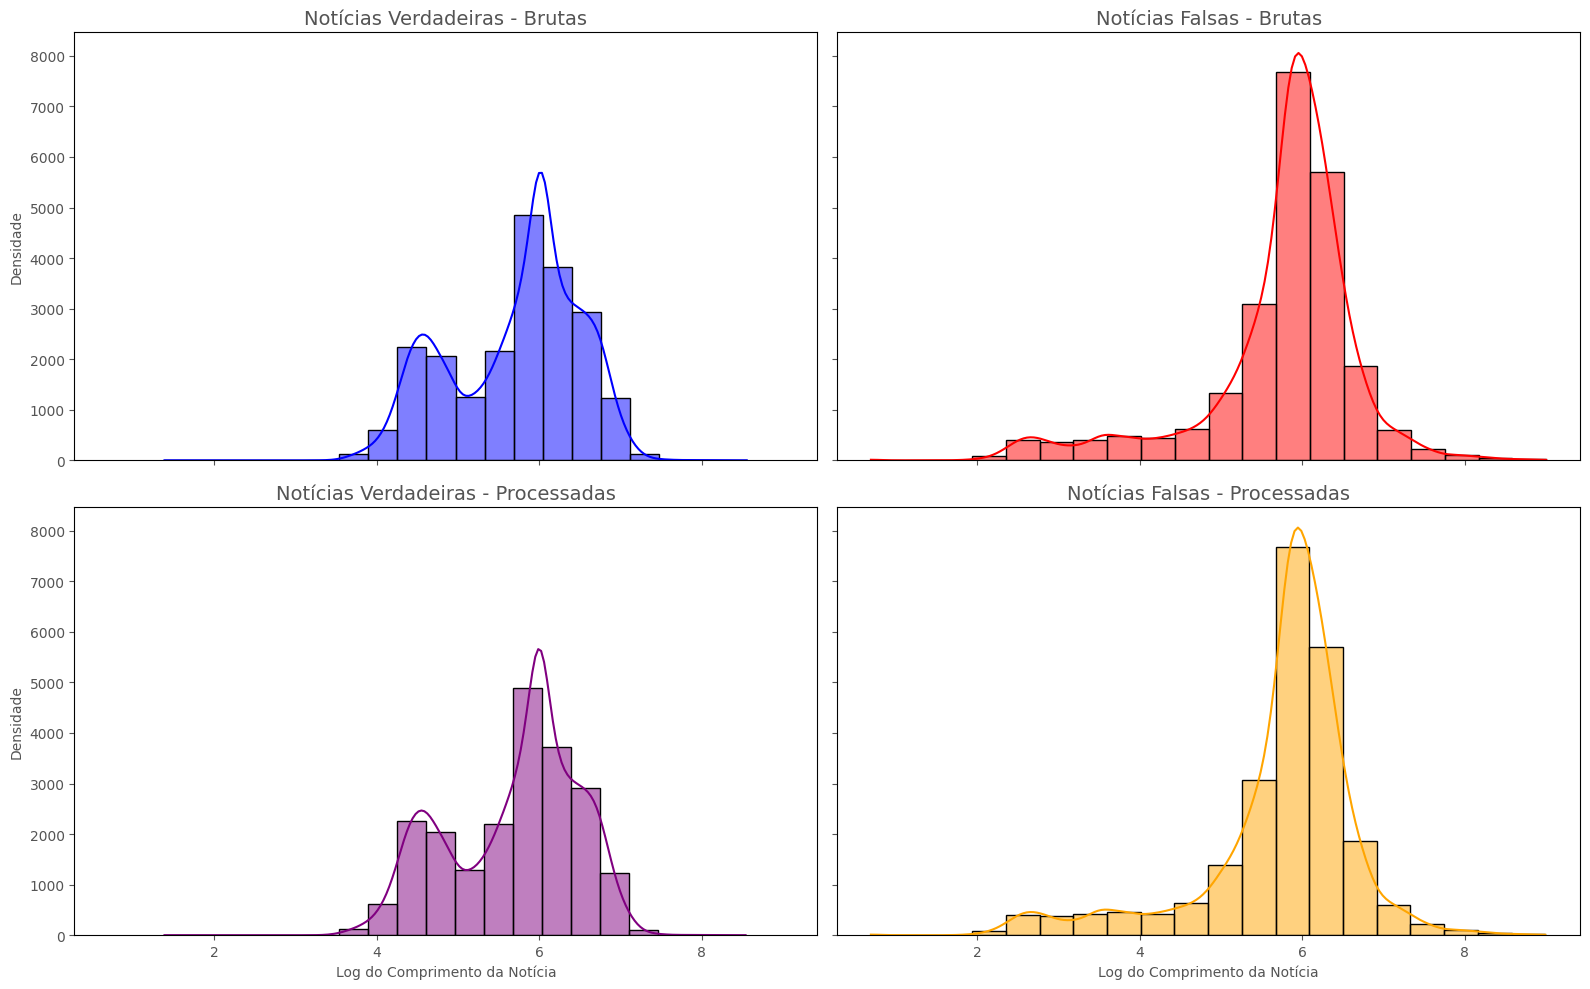

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

datasets = [
    (df_true['text'], "Notícias Verdadeiras - Brutas", "blue", axes[0, 0]),
    (df_false['text'], "Notícias Falsas - Brutas", "red", axes[0, 1]),
    (df[df['status'] == 1]['text'], "Notícias Verdadeiras - Processadas", "purple", axes[1, 0]),
    (df[df['status'] == 0]['text'], "Notícias Falsas - Processadas", "orange", axes[1, 1])
]

for text_data, title, color, ax in datasets:
  text_data = text_data.dropna()
  text_lengths = [len(news.split()) for news in text_data if len(news.split()) > 0]

  if text_lengths:
      text_lengths = np.log(text_lengths)
      sns.histplot(text_lengths, bins=20, color=color, kde=True, ax=ax)
      ax.set_title(title, fontsize=14, color="#545454")
      ax.set_xlabel("Log do Comprimento da Notícia", color="#545454")
      ax.set_ylabel("Densidade", color="#545454")
      ax.tick_params(axis='both', colors='#545454')

plt.tight_layout()
plt.show()

## Nuvem de palavras

### Notícias verdadeiras

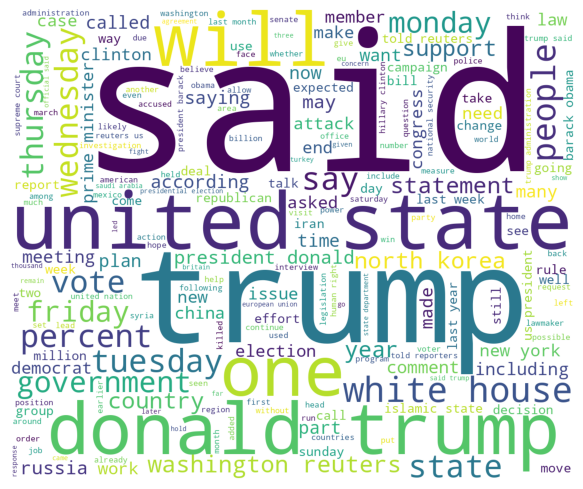

In [42]:
real_text = ' '.join(df[df['status'] == 1]['text'])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 2)

plt.imshow(WordCloud(width=1200, height=1000, background_color='white').generate(real_text))
plt.axis("off")
plt.show()

### Notícias falsas

(-0.5, 1199.5, 999.5, -0.5)

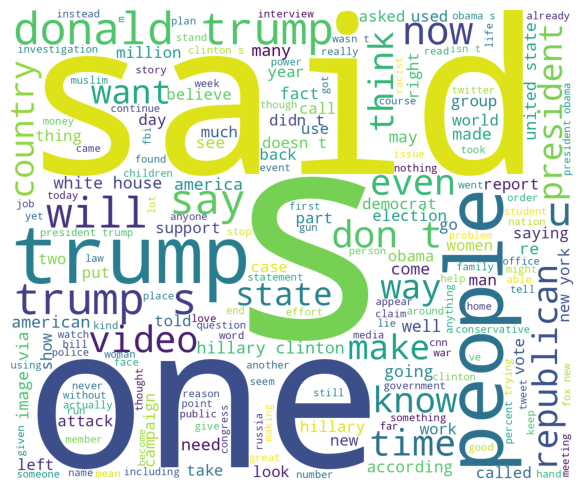

In [43]:
fake_text = ' '.join(df[df['status'] == 0]['text'])

plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=1200, height=1000, background_color='white').generate(fake_text))
plt.axis("off")

# Pré processamento

## Divisão da base de dados
- Primeira divisão: 80% para treino + validação, 20% para teste
- Segunda divisão: separando treino e validação

In [70]:
X = df['text'].values
y = df['status'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

Visualização da divisão realizada

In [71]:
print("Treino:", Counter(y_train))
print("Validação:", Counter(y_val))
print("Teste:", Counter(y_test))

Treino: Counter({0: 18785, 1: 17133})
Validação: Counter({0: 2348, 1: 2142})
Teste: Counter({0: 2348, 1: 2142})


## Tokenrização

In [72]:
def tokenize_and_pad(X_train, X_val, X_test):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(X_train)

  train_seq = tokenizer.texts_to_sequences(X_train)
  val_seq = tokenizer.texts_to_sequences(X_val)
  test_seq = tokenizer.texts_to_sequences(X_test)

  vocab_size = len(tokenizer.word_index) + 1
  max_length = max(len(sequence) for sequence in train_seq)

  train_seq = pad_sequences(train_seq, maxlen=max_length, padding='post', truncating='post')
  val_seq = pad_sequences(val_seq, maxlen=max_length, padding='post', truncating='post')
  test_seq = pad_sequences(test_seq, maxlen=max_length, padding='post', truncating='post')

  return train_seq, val_seq, test_seq, vocab_size, max_length

train_seq, val_seq, test_seq, vocab_size, max_length = tokenize_and_pad(X_train, X_val, X_test)

## Otimização
Converte arrays NumPy em um `tf.data.Dataset` otimizado para treinamento

In [73]:
def create_tf_dataset(X, y, batch_size=32):
    """
    :param X: Lista ou array contendo os textos das notícias.
    :param y: Lista ou array contendo os rótulos correspondentes.
    :return: Um `tf.data.Dataset` que carrega os dados de forma eficiente.
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    return dataset.cache().shuffle(len(X)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = create_tf_dataset(train_seq, y_train)
val_dataset = create_tf_dataset(val_seq, y_val)
test_dataset = create_tf_dataset(test_seq, y_test)

## Autotune


In [74]:
AUTOTUNE = tf.data.AUTOTUNE

def create_tf_dataset(X, y):
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  return dataset.cache().shuffle(len(X)).batch(32).prefetch(buffer_size=AUTOTUNE)

train_dataset = create_tf_dataset(train_seq, y_train)
val_dataset = create_tf_dataset(val_seq, y_val)
test_dataset = create_tf_dataset(test_seq, y_test)

# Modelo

## Definição do modelo

O modelo segue uma arquitetura com camadas de *embedding*, *dropout* e *pooling*:

In [75]:
embedding_dim = 16
num_classes = 2

model = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Compilação do modelo
Foram definidas a função de perda, o otimizador e as métricas:


In [76]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 7846, 16)            │       3,125,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7846, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,125,266 (11.92 MB)

 Trainable params: 3,125,266 (11.92 MB)

 Non-trainable params: 0 (0.00 B)

## Treinamento do modelo

In [77]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

epochs = 10

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 114s 99ms/step - accuracy: 0.5246 - loss: 0.6969 - val_accuracy: 0.5229 - val_loss: 0.6747
Epoch 2/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 141s 98ms/step - accuracy: 0.5994 - loss: 0.6644 - val_accuracy: 0.6220 - val_loss: 0.6130
Epoch 3/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 111s 99ms/step - accuracy: 0.7324 - loss: 0.5785 - val_accuracy: 0.6094 - val_loss: 0.5313
Epoch 4/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 114s 101ms/step - accuracy: 0.8257 - loss: 0.4385 - val_accuracy: 0.8846 - val_loss: 0.3384
Epoch 5/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 112s 100ms/step - accuracy: 0.8379 - loss: 0.3727 - val_accuracy: 0.8392 - val_loss: 0.3222
Epoch 6/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 140s 98ms/step - accuracy: 0.8906 - loss: 0.2889 - val_accuracy: 0.9690 - val_loss: 0.2151
Epoch 7/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 109s 97ms/step - accuracy: 0.8933 - loss: 0.2697 - val_accuracy: 0.9065 - val_loss: 0.2120
Epoch 8/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 113s 100ms/step - accurac

In [94]:
loss, acc = model.evaluate(test_dataset)

y_pred_train = model.predict(train_seq)
y_pred_test = model.predict(test_seq)
y_pred_val = model.predict(val_seq)

y_pred_train = np.argmax(y_pred_train, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)
y_pred_val = np.argmax(y_pred_val, axis=1)

141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9319 - loss: 0.1615
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


# Avaliação

## Relatório de métricas

In [93]:
print(f'Acurácia de treino: {accuracy_score(y_train, y_pred_train) * 100:.2f}%')
print(f'Acurácia de teste: {accuracy_score(y_test, y_pred_test) * 100:.2f}%')
print(f'Acurácia de validação: {accuracy_score(y_val, y_pred_val) * 100:.2f}%')


print(f'\nRelatóro de classificação de treino: \n\n{classification_report(y_train, y_pred_train)}')
print('-----------------------------------------------------')
print(f'\nRelatóro de classificação de teste: \n\n{classification_report(y_test, y_pred_test)}')
print('-----------------------------------------------------')
print(f'\nRelatóro de classificação de validação: \n\n{classification_report(y_val, y_pred_val)}')


Acurácia de treino: 91.91%
Acurácia de teste: 92.61%
Acurácia de validação: 91.49%

Relatóro de classificação de treino: 

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     18785
           1       0.86      0.99      0.92     17133

    accuracy                           0.92     35918
   macro avg       0.93      0.92      0.92     35918
weighted avg       0.93      0.92      0.92     35918

-----------------------------------------------------

Relatóro de classificação de teste: 

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      2348
           1       0.87      1.00      0.93      2142

    accuracy                           0.93      4490
   macro avg       0.93      0.93      0.93      4490
weighted avg       0.94      0.93      0.93      4490

-----------------------------------------------------

Relatóro de classificação de validação: 

              precision    recall

## Análise de perda e acurácia

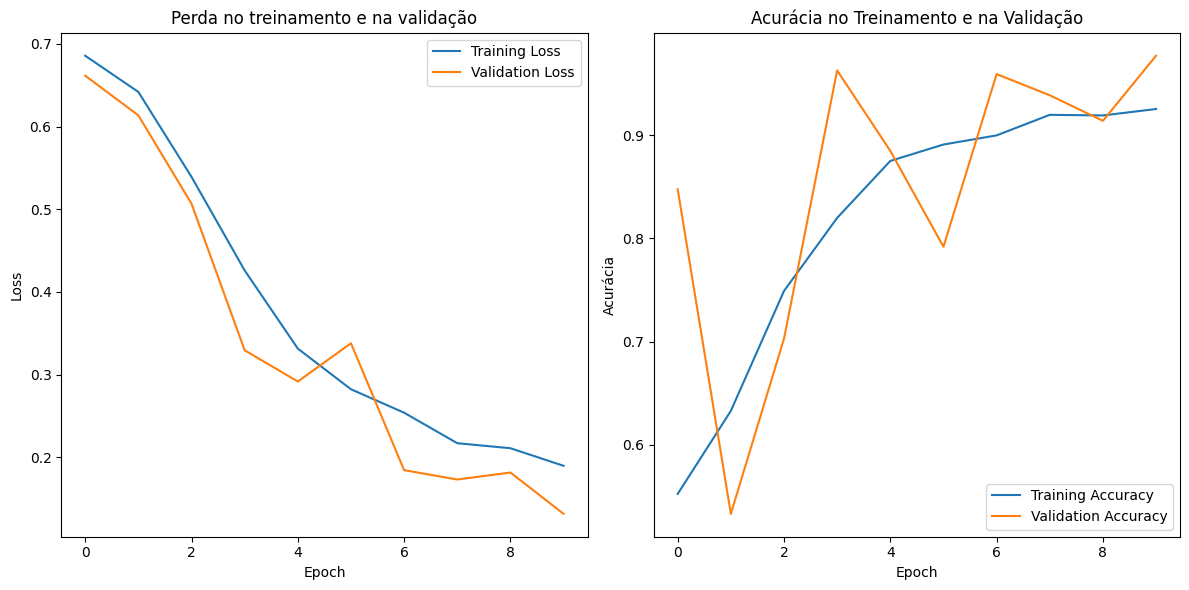

In [57]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Perda no treinamento e na validação')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acurácia')
plt.title('Acurácia no Treinamento e na Validação')
plt.legend()

plt.tight_layout()
plt.show()


## Matriz de confusão

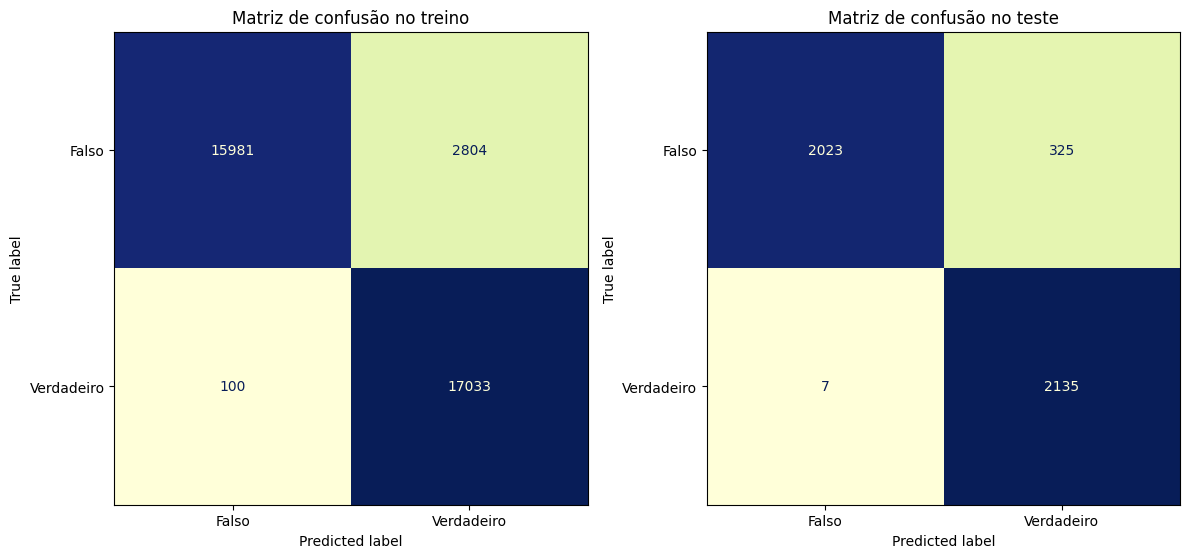

In [86]:
train_matrix = confusion_matrix(y_train, y_pred_train)
test_matrix = confusion_matrix(y_test, y_pred_test)

class_labels = ['Falso', 'Verdadeiro']

disp_train = ConfusionMatrixDisplay(confusion_matrix=train_matrix, display_labels=class_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_matrix, display_labels=class_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

disp_train.plot(ax=axs[0], cmap='YlGnBu', colorbar=False)
axs[0].set_title('Matriz de confusão no treino')

disp_test.plot(ax=axs[1], cmap='YlGnBu', colorbar=False)
axs[1].set_title('Matriz de confusão no teste')

plt.tight_layout()
plt.show()

### Treino

- 15.981 verdadeiros positivos
- 17.033 verdadeiros negativos
- 2.804 falsos positivos
- 100 falsos negativos

Baixo número de falsos negativos indica boa sensibilidade para a classe "Verdadeiro"

### Teste

- 2.023 verdadeiros positivos
- 2.135 verdadeiros negativos
- 325 falsos positivos
- 7 falsos negativos


Baixa taxa de falsos negativos reforça a capacidade do modelo de identificar corretamente a classe "Verdadeiro".

# Conclusão

O modelo de detecção de fake news alcançou um bom desempenho, com acurácia superior a 91% em todas as fases (treino, teste e validação). A precisão e o recall para ambas as classes foram equilibrados, demonstrando capacidade de identificar tanto notícias falsas quanto verdadeiras com eficácia.


## Limitações

- Apesar da alta acurácia, o modelo ainda apresenta falsos positivos e falsos negativos, o que pode comprometer a confiabilidade em cenários reais
- Pode ser sensível a viéses nos dados de treinamento, limitando a generalização para novos domínios


## Trabalhos futuros:

- Explorar técnicas de NLP avançadas, como transformers, para melhorar a detecção
- Ampliar o dataset com fontes mais diversas para reduzir viés